In [1]:
import csv

file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"

try:
    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        csv_reader = csv.reader(file)

        headers = next(csv_reader)
        print("Headers:", headers)

        print("\nTop 5 Rows:\n")
        for i, row in enumerate(csv_reader):
            if i == 5:   # stop after 5 rows
                break
            print(row)

except FileNotFoundError:
    print(f"The file at {file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


Headers: ['scrape_id', 'lat', 'lon', 'locationId', 'city', 'state', 'country', 'last_updated', 'AQI_IN', 'AQI_US', 'CO_PPB', 'H_PERCENT', 'NO2_PPB', 'O3_PPB', 'PM10_UGM3', 'PM2_5_UGM3', 'SO2_PPB', 'T_C', 'PM1_UGM3', 'TVOC_PPM', 'Noise_DB']

Top 5 Rows:

['624', '30.6324', '76.7244', '48F6EE546F34', 'Manauli', 'Punjab', 'India', '2025-11-09 17:22:00', '92', '149', '', '45', '', '', '68', '55', '', '24.5', '36.0', '0.21', '65.0']
['635', '30.6999', '76.835', 'PLLODA000621', 'Chandigarh', 'Chandigarh', 'India', '2025-11-09 17:23:00', '83', '137', '454.0', '38', '9.0', '13.0', '60', '50', '3.0', '19.0', '', '', '']
['636', '30.7058', '76.8532', '8680', 'Panchkula', 'Haryana', 'India', '2025-11-09 17:22:00', '82', '134', '309.0', '38', '10.0', '8.0', '60', '49', '2.0', '19.0', '', '', '']
['637', '30.6995', '76.8176', 'PLLODA000600', 'Chandigarh', 'Chandigarh', 'India', '2025-11-09 17:23:00', '87', '142', '511.0', '38', '8.0', '18.0', '60', '52', '3.0', '19.0', '', '', '']
['639', '30.6912'

In [31]:
import pandas as pd

# Load the full CSV — keep all historical data
df = pd.read_csv(file_path)

# Create a separate dataframe for unique stations (metadata only)
unique_stations = df[['locationId', 'lat', 'lon', 'city']].drop_duplicates().reset_index(drop=True)

# --- Outputs ---
print("=== Full Dataset ===")
print(df.head())  # just show first 5 rows of full data
print(f"\nTotal rows in full dataset: {len(df)}")

print("\n=== Unique Stations ===")
print(unique_stations)
print(f"\nTotal unique stations: {len(unique_stations)}")


=== Full Dataset ===
   scrape_id      lat      lon    locationId                        city  \
0        624  30.6324  76.7244  48F6EE546F34                     Manauli   
1        635  30.6999  76.8350  PLLODA000621                  Chandigarh   
2        636  30.7058  76.8532          8680                   Panchkula   
3        637  30.6995  76.8176  PLLODA000600                  Chandigarh   
4        639  30.6912  76.7443  48F6EE549CB8  Sahibzada Ajit Singh Nagar   

        state country         last_updated  AQI_IN  AQI_US  ...  H_PERCENT  \
0      Punjab   India  2025-11-09 17:22:00      92     149  ...         45   
1  Chandigarh   India  2025-11-09 17:23:00      83     137  ...         38   
2     Haryana   India  2025-11-09 17:22:00      82     134  ...         38   
3  Chandigarh   India  2025-11-09 17:23:00      87     142  ...         38   
4      Punjab   India  2025-11-09 17:22:00      67     112  ...         45   

   NO2_PPB  O3_PPB  PM10_UGM3  PM2_5_UGM3  SO2_PPB   

In [30]:
print(unique_locations)

       locationId      lat      lon                        city
0    48F6EE546F34  30.6324  76.7244                     Manauli
1    PLLODA000621  30.6999  76.8350                  Chandigarh
2            8680  30.7058  76.8532                   Panchkula
3    PLLODA000600  30.6995  76.8176                  Chandigarh
4    48F6EE549CB8  30.6912  76.7443  Sahibzada Ajit Singh Nagar
5         -160063  30.7160  76.8520                   Panchkula
6    48F6EE568468  30.6969  76.7556                  Chandigarh
7    E4B06332EC44  30.7127  76.8283                  Chandigarh
8    PLLODA000170  30.7046  76.7457                       Mauli
9    PLLODA000590  30.7034  76.7301                       Mauli
10   PLLODA000245  30.7150  76.7651                  Chandigarh
11          13876  30.7199  76.7386                  Chandigarh
12   PLLODA000685  30.7289  76.7817                  Chandigarh
13       VIR14156  30.7194  76.7181                       Mauli
14        VIR4221  30.7353  76.7911     

In [32]:
import pandas as pd
import folium
from IPython.display import display

df = pd.read_csv(file_path)

unique_locations = df[['locationId', 'lat', 'lon', 'city']].drop_duplicates()

center_lat = unique_locations['lat'].mean()
center_lon = unique_locations['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

for _, row in unique_locations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"ID: {row['locationId']}\nCity: {row['city']}",
    ).add_to(m)

display(m)


## GLOBAL SPATIAL AUTOCORRELATION
calc the Global Moran's I to check if the particular parameter is clustered in tricity

In [13]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import KNN
from esda import Moran
import numpy as np

file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)
df = df.sort_values('last_updated').drop_duplicates('locationId', keep='last')

pollutants = [
    'AQI_IN',
    'CO_PPB',
    'NO2_PPB',
    'O3_PPB',
    'PM10_UGM3',
    'PM2_5_UGM3',
    'SO2_PPB'
]

for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors='coerce')


gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs='EPSG:4326'
)

w = KNN.from_dataframe(gdf, k=6)
w.transform = 'R'    

results = []


def interpret_moran(i, p):
    if p < 0.05 and abs(i) > 0.3:
        return "Strong spatial clustering"
    elif p < 0.05:
        return "Moderate spatial clustering"
    else:
        return "No significant spatial clustering"


for col in pollutants:

    series = gdf[col]

    if series.isna().all():
        results.append([col, np.nan, np.nan, np.nan, "No valid data"])
        continue

    series = series.fillna(series.mean())

    if series.std() == 0:
        results.append([col, np.nan, np.nan, np.nan, "No variance in data"])
        continue

    mi = Moran(series, w)

    interpretation = interpret_moran(mi.I, mi.p_sim)

    results.append([
        col,
        round(mi.I, 4),
        round(mi.p_sim, 5),
        round(mi.z_sim, 4),
        interpretation
    ])


results_df = pd.DataFrame(
    results,
    columns=["Pollutant", "Moran_I", "p-value", "z-score", "Interpretation"]
)

print(results_df)


    Pollutant  Moran_I  p-value  z-score                     Interpretation
0      AQI_IN   0.0326    0.155   1.0037  No significant spatial clustering
1      CO_PPB   0.0835    0.095   1.4084  No significant spatial clustering
2     NO2_PPB   0.3685    0.002   4.4945          Strong spatial clustering
3      O3_PPB   0.3433    0.001   4.1159          Strong spatial clustering
4   PM10_UGM3   0.0233    0.203   0.7663  No significant spatial clustering
5  PM2_5_UGM3   0.0335    0.197   0.7994  No significant spatial clustering
6     SO2_PPB   0.1573    0.033   2.3452        Moderate spatial clustering


In [33]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import KNN
from esda import Moran
import numpy as np
from collections import Counter


file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)

df['last_updated'] = pd.to_datetime(df['last_updated'])

pollutants = [
    'AQI_IN',
    'CO_PPB',
    'NO2_PPB',
    'O3_PPB',
    'PM10_UGM3',
    'PM2_5_UGM3',
    'SO2_PPB'
]

for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df = df[df['lat'] > 30.60]



def interpret_moran(moran_I, p):
    if p < 0.05 and abs(moran_I) > 0.3:
        return "Strong"
    elif p < 0.05:
        return "Moderate"
    else:
        return "None"


final_counts = {col: Counter() for col in pollutants}



for ts, sub in df.groupby('last_updated'):

    if len(sub) < 6:
        continue

    gdf = gpd.GeoDataFrame(
        sub,
        geometry=gpd.points_from_xy(sub['lon'], sub['lat']),
        crs='EPSG:4326'
    )

    try:
        w = KNN.from_dataframe(gdf, k=6)
        w.transform = 'R'
    except:
        continue

    for col in pollutants:

        series = gdf[col]

        if series.isna().all():
            final_counts[col]["None"] += 1
            continue

        series = series.fillna(series.mean())

        if series.std() == 0:
            final_counts[col]["None"] += 1
            continue

        try:
            mi = Moran(series, w)
            interpretation = interpret_moran(mi.I, mi.p_sim)
        except:
            interpretation = "None"

        final_counts[col][interpretation] += 1



summary_df = pd.DataFrame([
    [
        col,
        final_counts[col]["Strong"],
        final_counts[col]["Moderate"],
        final_counts[col]["None"]
    ]
    for col in pollutants
], columns=["Pollutant", "Strong_Count", "Moderate_Count", "None_Count"])

print("\n=== Final Moran's I Spatial Pattern Summary ===\n")
print(summary_df)


C:\Users\Narula\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Narula\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Narula\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Narula\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Narula\


=== Final Moran's I Spatial Pattern Summary ===

    Pollutant  Strong_Count  Moderate_Count  None_Count
0      AQI_IN           140             485         969
1      CO_PPB           289             546         759
2     NO2_PPB           848             535         211
3      O3_PPB           645             458         491
4   PM10_UGM3           124             404        1066
5  PM2_5_UGM3           143             471         980
6     SO2_PPB           289             321         984


- **Strong_Norm** → Strong spatial clustering
- **Moderate_Norm** → Moderate spatial clustering
- **None_Norm** → No meaningful spatial clustering

*(spatial clustering - whether nearby monitoring stations have similar pollutant levels)*


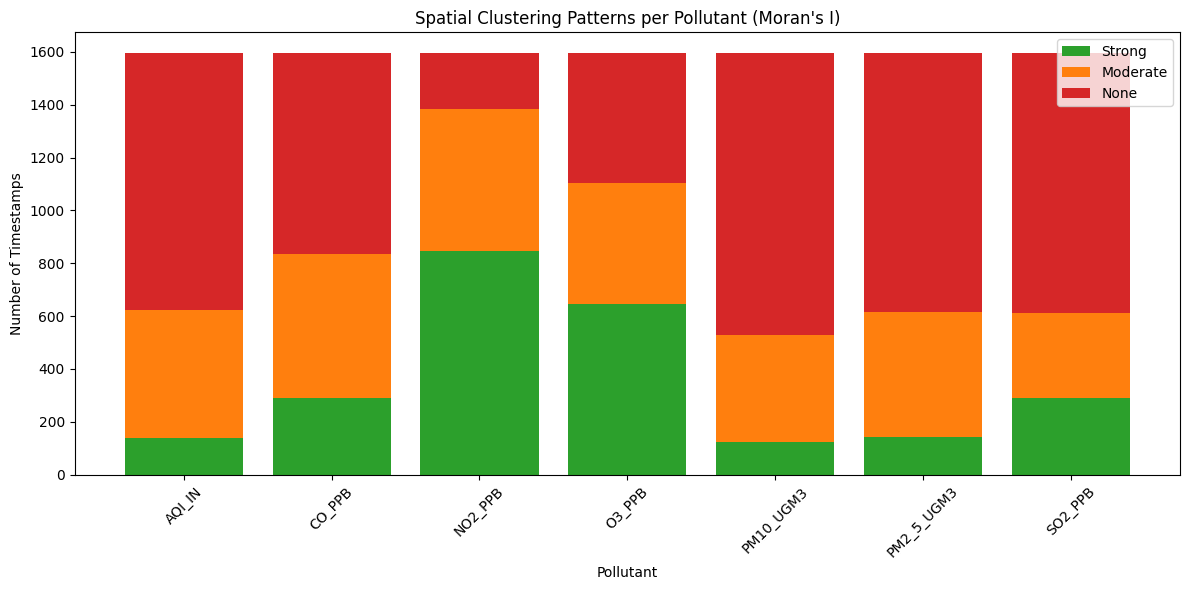

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Your summary data
data = {
    "Pollutant": ["AQI_IN", "CO_PPB", "NO2_PPB", "O3_PPB", "PM10_UGM3", "PM2_5_UGM3", "SO2_PPB"],
    "Strong_Count": [140, 289, 848, 645, 124, 143, 289],
    "Moderate_Count": [485, 546, 535, 458, 404, 471, 321],
    "None_Count": [969, 759, 211, 491, 1066, 980, 984]
}

summary_df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12,6))
plt.bar(summary_df["Pollutant"], summary_df["Strong_Count"], label="Strong", color="#2ca02c")
plt.bar(summary_df["Pollutant"], summary_df["Moderate_Count"], bottom=summary_df["Strong_Count"], label="Moderate", color="#ff7f0e")
plt.bar(summary_df["Pollutant"], summary_df["None_Count"], bottom=summary_df["Strong_Count"] + summary_df["Moderate_Count"], label="None", color="#d62728")

plt.xlabel("Pollutant")
plt.ylabel("Number of Timestamps")
plt.title("Spatial Clustering Patterns per Pollutant (Moran's I)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## LOCAL SPATIAL AUTOCORRELATION
### LISA - local Moran's I

In [23]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import DistanceBand
from esda import Moran_Local
import numpy as np

# ------------------------------------------------
# LOAD & CLEAN DATA
# ------------------------------------------------
file_path = r"C:\Users\Narula\india_selected_cities_cleaned.csv"
df = pd.read_csv(file_path)

# Remove rows that are completely empty
df = df.dropna(how="all")

# Convert measurement columns to numeric (coerce blank cells to NaN)
num_cols = [
    'AQI_IN','AQI_US','CO_PPB','H_PERCENT','NO2_PPB','O3_PPB',
    'PM10_UGM3','PM2_5_UGM3','SO2_PPB','T_C','PM1_UGM3',
    'TVOC_PPM','Noise_DB'
]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ------------------------------------------------
# GET LATEST READING PER SENSOR
# ------------------------------------------------
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Get most recent reading for each location
df = (
    df.sort_values('last_updated')
      .groupby('locationId')
      .tail(1)
      .reset_index(drop=True)
)

# ------------------------------------------------
# CONVERT TO GEODATAFRAME
# ------------------------------------------------
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs='EPSG:4326'
)

# Project to meters
gdf = gdf.to_crs(epsg=3857)

# ------------------------------------------------
# BUILD A FULLY CONNECTED WEIGHT MATRIX
# ------------------------------------------------
threshold_meters = 30000  # Start with 30 km
w = DistanceBand.from_dataframe(gdf, threshold=threshold_meters)

while len(w.islands) > 0:
    threshold_meters += 20000
    print(f"Increasing search radius to {threshold_meters/1000:.1f} km...")
    w = DistanceBand.from_dataframe(gdf, threshold=threshold_meters)

print("\n✔ Spatial weights fully connected!")
w.transform = 'R'

# ------------------------------------------------
# RUN LISA (Local Moran’s I)
# ------------------------------------------------
pollutant = "AQI_IN"

# Replace missing values with mean
values = gdf[pollutant].fillna(gdf[pollutant].mean())

lisa = Moran_Local(values, w)

# ------------------------------------------------
# CLASSIFICATION
# ------------------------------------------------
cluster_labels = np.array(["Not Significant"] * len(gdf))
sig = lisa.p_sim < 0.05

cluster_labels[sig & (values > values.mean()) & (lisa.Is > 0)] = "High-High"
cluster_labels[sig & (values < values.mean()) & (lisa.Is > 0)] = "Low-Low"
cluster_labels[sig & (values > values.mean()) & (lisa.Is < 0)] = "High-Low"
cluster_labels[sig & (values < values.mean()) & (lisa.Is < 0)] = "Low-High"

# ------------------------------------------------
# FINAL RESULTS
# ------------------------------------------------
results = pd.DataFrame({
    "location_id": gdf['locationId'],
    "pollutant": pollutant,
    "moran_I": lisa.Is,
    "p_value": lisa.p_sim,
    "cluster": cluster_labels
})

print("\n=== LISA Results ===")
print(results.head())



✔ Spatial weights fully connected!

=== LISA Results ===
    location_id pollutant   moran_I  p_value          cluster
0  48F6EE5481E0    AQI_IN -0.033320    0.403  Not Significant
1         12428    AQI_IN -0.014953    0.368  Not Significant
2          8680    AQI_IN -0.098396    0.147  Not Significant
3  PLLODA000685    AQI_IN -0.000908    0.160  Not Significant
4      VIR14156    AQI_IN -0.008169    0.083  Not Significant
